In [ ]:
import torch
import torchvision
from torchvision import models, transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from PIL import Image
import os

In [2]:
dataset_name = "ForestSegmented"

In [54]:

root_dir = "/home/lck/Schreibtisch/" + dataset_name

In [ ]:
# mount google drive and copy working folder into local storage

from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/PMML/Forest Segmented" /content

In [ ]:
!cp -r /content/drive/MyDrive/PMML/AMAZON /content/

In [4]:
# delegate computations to the gpu if avialable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# define transformation for the input image

preprocess = transforms.Compose([
    transforms.Resize((256, 256)), #ForestSegmentend already is in 256x256
    transforms.ToTensor(),
])

# Define transformation for the masks
mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


In [145]:
import rasterio
class AmazonDataset(Dataset):
    def __init__(self, root_dir=root_dir, transform_images=None, transform_masks=None):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(os.path.join(root_dir, "image")))
        self.masks = sorted(os.listdir(os.path.join(root_dir, "label")))
        self.transform_images = transform_images
        self.transform_masks = transform_masks

        print(f" #images == #masks = {len(self.images) == len(self.masks)}")

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_dir = os.path.join(self.root_dir, "image")
        mask_dir = os.path.join(self.root_dir, "label")

        with rasterio.open(os.path.join(image_dir, self.images[index])) as src:
            image = src.read()
            image = torch.from_numpy(image).float()
            print(image.shape)
        with rasterio.open(os.path.join(mask_dir, self.masks[index])) as src:
            mask = src.read()
            mask = torch.from_numpy(mask).float()
            print(mask.shape)
        return image, mask

In [7]:
class ForestSegmentedDataset(Dataset):
    def __init__(self, dataset, root_dir, transform_images=None, transform_masks=None):
        self.data = dataset
        self.root_dir = root_dir
        self.transform_images = transform_images
        self.transform_masks = transform_masks

        print(len(dataset['image']) == len(dataset['mask']))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_dir = os.path.join(self.root_dir, "images")
        mask_dir = os.path.join(self.root_dir, "masks")


        image = Image.open(os.path.join(image_dir, self.data.iloc[index]['image'])).convert("RGB")
        mask = Image.open(os.path.join(mask_dir, self.data.iloc[index]['mask'])).convert("L") # Masks are typically single channel (grayscale)

        if self.transform_images:
            image = self.transform_images(image)
        if self.transform_masks:
            mask = self.transform_masks(mask)

        return image, mask

In [14]:
def plot_result(image, mask, ground_truth):
  # Denormalize image for plotting
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  image = image.cpu().squeeze(0) # Remove batch dimension, shape (C, H, W)
  image = torch.clamp(image, 0 ,1) # clip values between 0 and 1
  image = image.permute(1,2,0) # Correctly permute to (H, W, C) for imshow

# define 3 subplots Image | Prediction | Ground Truth
  plt.figure(figsize=(12, 12))
  plt.subplot(1, 3, 1)
  plt.imshow(image) # imshow expects (H, W, C) for color images
  plt.title('Original Image')
  plt.subplot(1, 3, 2)
  plt.imshow(mask) # mask should be (H, W)
  plt.title('Predicted Mask')
  plt.subplot(1, 3, 3)
  plt.imshow(ground_truth)
  plt.title('Ground Truth')
  plt.show()

In [136]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, num_classes=1, plot_results=True):
    
    metrics = {
        "train": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": []
        },
        "val": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": [],
            "iou_per_epoch": [],
            "dice_per_epoch": [],
            "tp_per_epoch": [],
            "fp_per_epoch": [],
            "tn_per_epoch": [],
            "fn_per_epoch": []
        }
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # ===== TRAINING =====
        model.train()
        epoch_train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader, 1):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            metrics["train"]["loss_per_batch"].append(loss.item())

            print(f"  Train batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        metrics["train"]["avg_loss_per_epoch"].append(avg_train_loss)

        # Validation loop incoming
        model.eval()
        epoch_val_loss = 0.0
        tpsum, tnsum, fpsum, fnsum = 0.0, 0.0, 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader, 1):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                print(f"outputs.shape: {outputs.shape}")
                print(f"outputs.squeeze(1).shape: {outputs.squeeze(1).shape}")
                print(f"masks.shape: {masks.shape}")
                # Get metrics
                epoch_val_loss += loss.item()
                tp, fp, fn, tn = smp.metrics.get_stats((outputs > 0.5).long().squeeze(1), masks.long().squeeze(1), mode='binary')

                # safe metrics
                tpsum += tp.sum().item()
                tnsum += tn.sum().item()
                fpsum += fp.sum().item()
                fnsum += fn.sum().item()

                print(
                    f"  Val batch {batch_idx}/{len(val_loader)} | "
                    f"Loss: {loss.item():.4f}"
                )
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        dice_epoch = (2 * tpsum) / (2 * tpsum + fpsum + fnsum + 1e-7)
        iou = tpsum / (tpsum + fpsum + fnsum + 1e-7)
        
        metrics["val"]["avg_loss_per_epoch"].append(avg_val_loss)
        metrics["val"]["iou_per_epoch"].append(iou)
        metrics["val"]["dice_per_epoch"].append(dice_epoch)
        metrics["val"]["tp_per_epoch"].append(tpsum)
        metrics["val"]["tn_per_epoch"].append(tnsum)
        metrics["val"]["fp_per_epoch"].append(fpsum)
        metrics["val"]["fn_per_epoch"].append(fnsum)

        print(
            f"\nEpoch Summary:"
            f"\n  Train Loss: {avg_train_loss:.4f}"
            f"\n  Val Loss:   {avg_val_loss:.4f}"
            f"\n  Val IoU:    {metrics['val']['iou_per_epoch'][-1]:.4f}"
            f"\n  Val Dice:  {metrics['val']['dice_per_epoch'][-1]:.4f}"
        )

    torch.save(model.state_dict(), "forest_model_final.pth")
    print("\nTraining finished.")

    return metrics


In [140]:
#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #optimizer

In [64]:
# define the model, the loss-function and optimzer
model = smp.PAN(
    pretrained=True,
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 3,
    classes = 1
    ).to(device)

# set model to evaluation mode
model.eval()

# simple prediction function
def predict(image, threshold=0.5):
    model.eval()
    with torch.no_grad():
        output = model(image)           # [1, 1, H, W]
        prob = torch.sigmoid(output)    # [0,1]
        pred = (prob > threshold).float()

    return pred.squeeze().cpu().numpy()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load data into dataframe
full_dataset = pd.read_csv(os.path.join(root_dir, 'meta_data.csv'))

# split dataset into training and validation data
train_data, val_data = train_test_split(full_dataset, test_size=0.2, random_state=42)

In [ ]:

# load data into Dataset-class for processing in the model
training_data = ForestSegmentedDataset(train_data, root_dir, transform_images=preprocess, transform_masks=mask_transform)
validation_data = ForestSegmentedDataset(val_data, root_dir, transform_images=preprocess, transform_masks=mask_transform)

In [ ]:
import random
i = random.randint(0, len(training_data)-1)

image, target = training_data[1005]
# remove the batch dimension
image = image.unsqueeze(0).to(device)

# make numpy array out of mask for plotting purpose
target = np.array(target)
image_mask = predict(image)


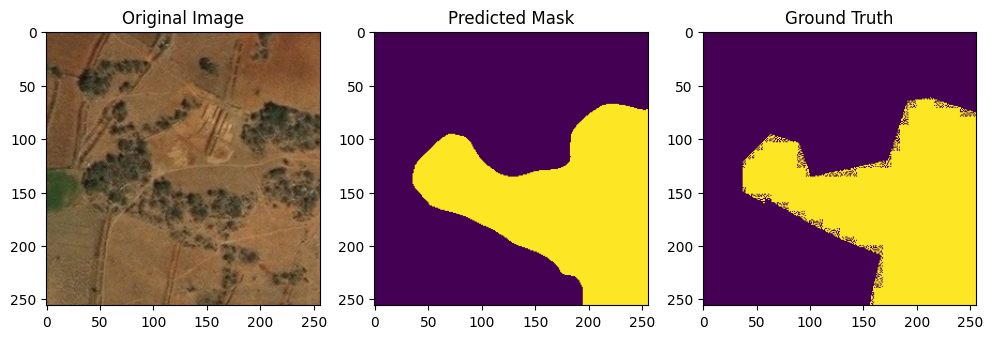

In [27]:
plot_result(image, image_mask, target)

In [114]:

train_loader = DataLoader(training_data, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation_data, batch_size=4, shuffle=False, pin_memory=True)
print(len(train_loader))

1022


In [149]:
# define model for Amazondataset
model_amazon = smp.PAN(
    pretrained=True,
    encoder_name = 'resnet101',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1
    ).to(device)

# set model to evaluation mode
model.eval()

# simple prediction function
def predict(md,image, threshold=0.5):
    model = md
    model.eval()
    with torch.no_grad():
        output = model(image)           # [1, 1, H, W]
        prob = torch.sigmoid(output)    # [0,1]
        pred = (prob > threshold).float()

    return pred.squeeze().cpu().numpy()

In [161]:
train_data_amazon = AmazonDataset(os.path.join(root_dir, "Training"), preprocess, mask_transform)
val_data_amazon = AmazonDataset(os.path.join(root_dir, "Validation"), preprocess, mask_transform)

 #images == #masks = True
 #images == #masks = True


In [143]:
train_loader_amazon = DataLoader(train_data_amazon, batch_size=4, shuffle=True, pin_memory=True)
val_loader_amazon = DataLoader(val_data_amazon, batch_size=4, shuffle=False, pin_memory=True)

In [147]:
val_metrics = train_model(model_amazon, criterion, optimizer, 20, train_loader_amazon, val_loader_amazon, device)


Epoch [1/20]
  Train batch 1/125 | Loss: 0.4268
  Train batch 2/125 | Loss: 0.5360
  Train batch 3/125 | Loss: 0.5443
  Train batch 4/125 | Loss: 0.6298
  Train batch 5/125 | Loss: 0.4711
  Train batch 6/125 | Loss: 0.5636
  Train batch 7/125 | Loss: 0.4719
  Train batch 8/125 | Loss: 0.6254
  Train batch 9/125 | Loss: 0.5282
  Train batch 10/125 | Loss: 0.4348
  Train batch 11/125 | Loss: 0.4457
  Train batch 12/125 | Loss: 0.6094
  Train batch 13/125 | Loss: 0.4623
  Train batch 14/125 | Loss: 0.4720
  Train batch 15/125 | Loss: 0.4040
  Train batch 16/125 | Loss: 0.4722
  Train batch 17/125 | Loss: 0.5265
  Train batch 18/125 | Loss: 0.3969
  Train batch 19/125 | Loss: 0.3098
  Train batch 20/125 | Loss: 0.4849
  Train batch 21/125 | Loss: 0.5345
  Train batch 22/125 | Loss: 0.4893
  Train batch 23/125 | Loss: 0.4687
  Train batch 24/125 | Loss: 0.5070
  Train batch 25/125 | Loss: 0.4228
  Train batch 26/125 | Loss: 0.3710
  Train batch 27/125 | Loss: 0.2648
  Train batch 28/125 | 

torch.Size([4, 512, 512])
torch.Size([1, 512, 512])


/tmp/ipykernel_2471/1695725281.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  target = np.array(target)


TypeError: Invalid shape (1, 512, 512) for image data

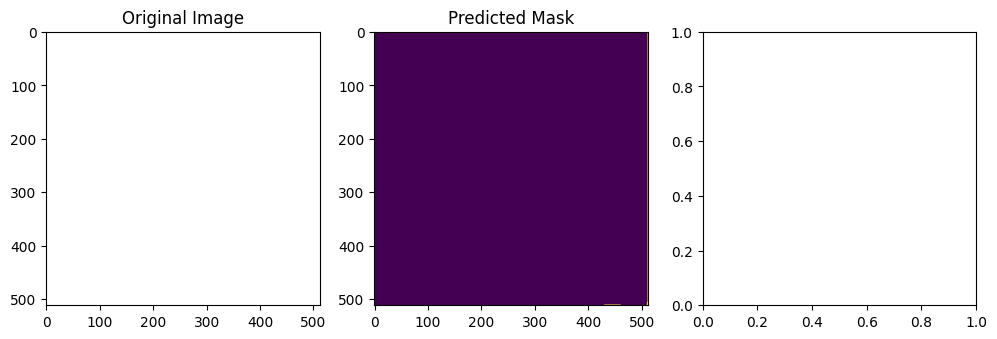

In [153]:
import random
i = random.randint(0, len(training_data)-1)

image, target = train_data_amazon[105]
# remove the batch dimension
image = image.unsqueeze(0).to(device)

# make numpy array out of mask for plotting purpose
target = np.array(target)
image_mask = predict(model_amazon,image)
#print(image)
#print(image_mask)
plot_result(image, image_mask, target)

In [138]:
def plot_metrics(metrics):

  plt.figure(figsize=(14,5))
  plt.subplot(1,3,1)
  plt.plot(metrics['train']['avg_loss_per_epoch'], label='Training Loss')
  plt.plot(metrics['val']['avg_loss_per_epoch'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.grid(True)
  """
  metrics['val']['iou_per_epoch'] = [
    x.detach().cpu().item() for x in metrics['val']['iou_per_epoch']
  ]
  """
  plt.subplot(1,3,2)
  plt.plot(metrics['val']['iou_per_epoch'], label='Validation IoU')
  plt.xlabel('Epoch')
  plt.ylabel('IoU')
  plt.legend()
  plt.title('Validation IoU')
  plt.grid(True)

  plt.subplot(1,3,3)
  plt.plot(metrics['val']['dice_per_epoch'], label='Dice')
  plt.xlabel('Epoch')
  plt.ylabel('Dice')
  plt.legend()
  plt.title('Validation Dice')
  plt.grid(True)

  plt.show()


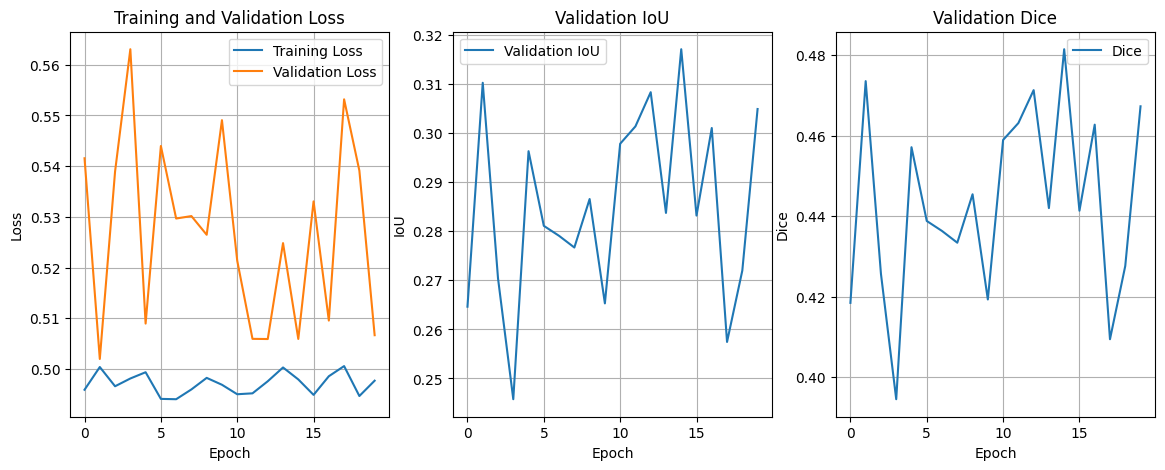

In [148]:
plot_metrics(val_metrics)

In [63]:
torch.save(model.state_dict(), './models/forest_model_PAN.pth')